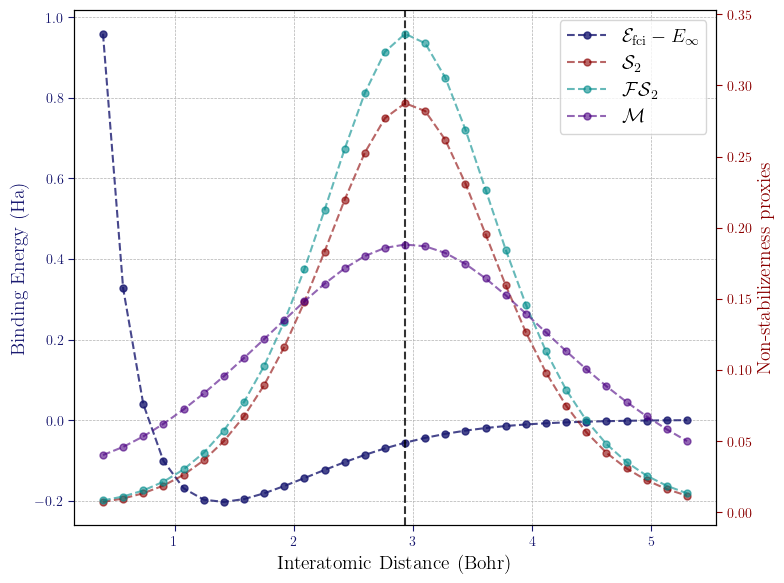

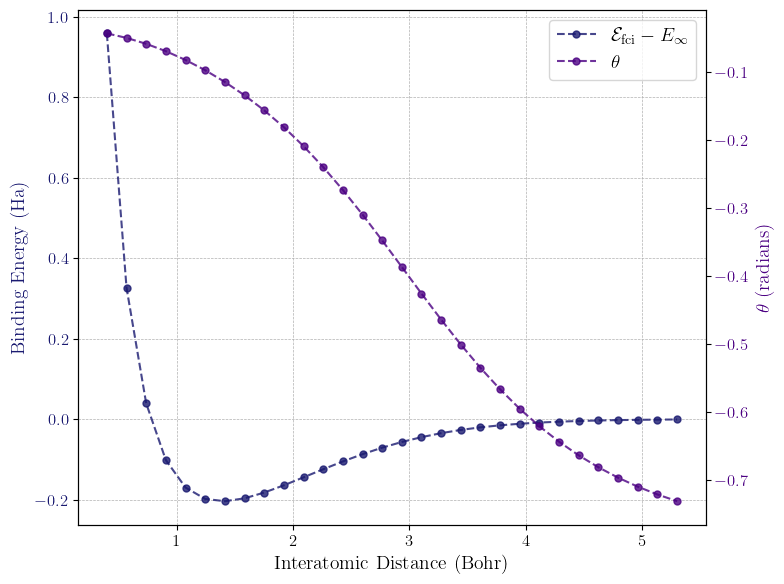

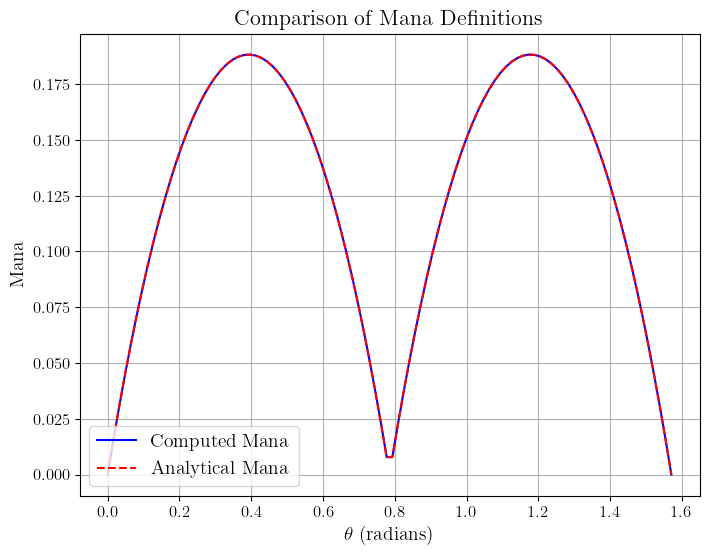

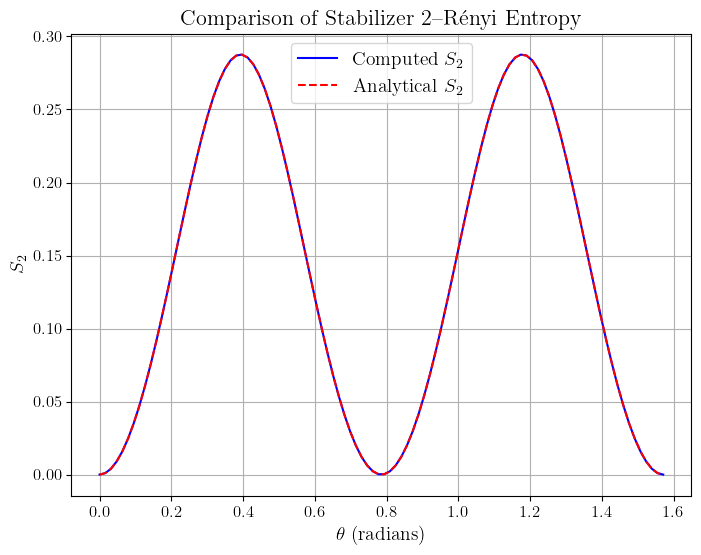

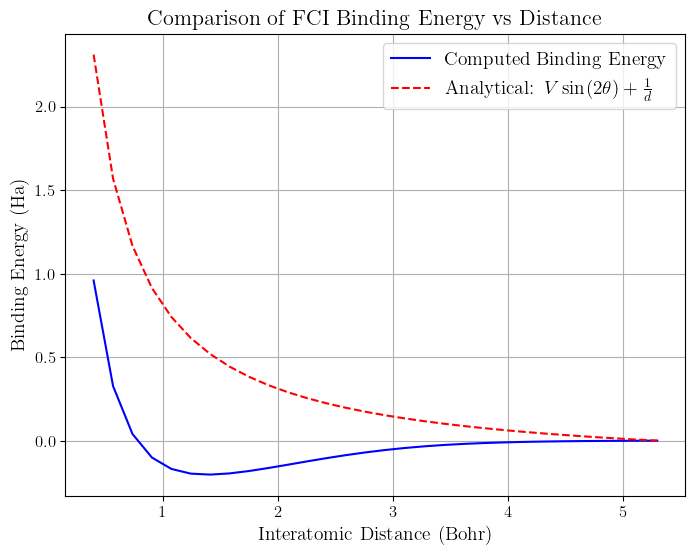

In [ ]:
# -*- coding: utf-8 -*-
#
# Written by Matthieu Sarkis (https://github.com/MatthieuSarkis).
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

r"""
This module performs FCI calculations for H$_2$ and computes various non-stabilizerness proxies,
including the stabilizer Rényi entropy and Mana. It also generates plots showing the FCI binding energy,
non-stabilizerness proxies, the extracted theta values, and comparisons between the numerical and
analytical expressions for the mana, the stabilizer 2–Rényi entropy, and the FCI binding energy.

Analytical derivations:

1. For the Mana, one finds that (after a detailed derivation)
   \[
   \|W\|_1=8\Bigl[1+|\cos(2\theta)|+|\sin(2\theta)|\Bigr],
   \]
   so that, normalizing by the stabilizer value 16,
   \[
   \mathcal{M}(\theta)=\ln\!\Bigl(\frac{1+|\cos(2\theta)|+|\sin(2\theta)|}{2}\Bigr).
   \]

2. For the stabilizer 2–Rényi entropy, one obtains:
   \[
   S_2(\theta)=-\ln\!\Bigl(1-\frac{1}{4}\sin^2(4\theta)\Bigr).
   \]

3. For the FCI energy, we write the electronic part as
   \[
   E_{\rm elec}(\theta)=E_d+H_{12}\sin(2\theta),
   \]
   and include the nucleus–nucleus repulsion term
   \[
   E_{\rm nn}(d)=\frac{1}{d}.
   \]
   Taking the dissociation limit (where \(E_d\) is reached) as reference,
   the total binding energy is given by
   \[
   E_{\rm bind}(d)=E_{\rm tot}(d)-E_d=H_{12}\sin(2\theta(d))+\frac{1}{d}.
   \]
   Defining \(V=H_{12}\) (with \(V<0\) for binding) we have the analytical expression
   \[
   E_{\rm bind}^{\rm anal}(d)=V\sin(2\theta(d))+\frac{1}{d}.
   \]

Usage:
    Run the module directly to execute the calculations and display/save the plots.
"""

from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci
from pyscf.fci import cistring
from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set LaTeX fonts and style for plotting.
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
    "figure.figsize": (8, 6),
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 14
})

# Global constants: 2x2 matrices for a single fermionic mode.
I2: np.ndarray = np.array([[1, 0], [0, 1]], dtype=complex)
c: np.ndarray = np.array([[0, 0], [1, 0]], dtype=complex)
cd: np.ndarray = np.array([[0, 1], [0, 0]], dtype=complex)
eta: np.ndarray = c + cd        # Majorana operator: η = c + c†
chi: np.ndarray = 1j * (c - cd)   # Majorana operator: χ = i(c - c†)


def local_operator(v1: int, v2: int) -> np.ndarray:
    r"""Return the local operator for one mode: η^(v1) * χ^(v2).

    If v1 or v2 is 0, the corresponding operator is replaced by the identity.

    Args:
        v1 (int): Exponent for η operator (0 or 1).
        v2 (int): Exponent for χ operator (0 or 1).

    Returns:
        np.ndarray: The 2×2 local operator.
    """
    op = I2
    if v1 == 1:
        op = np.dot(op, eta)
    if v2 == 1:
        op = np.dot(op, chi)
    return op


def overall_phase(v: List[int]) -> complex:
    r"""Compute the overall phase factor i^(∑_{i>j} v_i * v_j) for an 8-component binary vector.

    Args:
        v (List[int]): An 8-element binary vector.

    Returns:
        complex: The computed phase factor.
    """
    exponent = 0
    for i in range(1, len(v)):
        for j in range(i):
            exponent += v[i] * v[j]
    return (1j) ** exponent


def P_v_operator(v: List[int]) -> np.ndarray:
    r"""Construct the full 16×16 operator P_v for 4 modes from an 8-bit binary vector.

    The operator is defined as the tensor product of local operators
    multiplied by an overall phase factor.

    Args:
        v (List[int]): A binary vector of length 8.

    Returns:
        np.ndarray: The 16×16 operator P_v.

    Raises:
        ValueError: If the length of v is not 8.
    """
    if len(v) != 8:
        raise ValueError("v must be a binary vector of length 8")
    op = 1  # Start with scalar 1 and build via tensor product.
    for a in range(4):
        op_local = local_operator(v[2 * a], v[2 * a + 1])
        op = np.kron(op, op_local)
    return overall_phase(v) * op


def state_psi(theta: float) -> np.ndarray:
    r"""Construct the state |\psi(θ)⟩ in a 16-dimensional Hilbert space.

    The state is defined as:
        |\psi(θ)⟩ = cos(θ)|1,1,0,0⟩ + sin(θ)|0,0,1,1⟩,
    where the four modes correspond to:
      - Mode 1: α orbital 0,
      - Mode 2: β orbital 0,
      - Mode 3: α orbital 1,
      - Mode 4: β orbital 1.

    Args:
        theta (float): Angle parameter in radians.

    Returns:
        np.ndarray: The 16-dimensional state vector.
    """
    ket0 = np.array([1, 0], dtype=complex)
    ket1 = np.array([0, 1], dtype=complex)
    state_1100 = np.kron(np.kron(ket1, ket1), np.kron(ket0, ket0))
    state_0011 = np.kron(np.kron(ket0, ket0), np.kron(ket1, ket1))
    return np.cos(theta) * state_1100 + np.sin(theta) * state_0011


def expected_value(theta: float, v: List[int]) -> complex:
    r"""Compute the expectation value ⟨ψ(θ)|P_v|ψ(θ)⟩.

    Args:
        theta (float): Angle parameter in radians.
        v (List[int]): An 8-bit binary vector.

    Returns:
        complex: The computed expectation value.
    """
    psi = state_psi(theta)
    P_v = P_v_operator(v)
    return np.vdot(psi, P_v.dot(psi))


def stabilizer_Renyi_entropy(theta: float, alpha: int = 2) -> float:
    r"""Compute the stabilizer Rényi entropy M_α for the state |\psi(θ)⟩.

    The entropy is defined as:
        M_α = 1/(1-α) * ln(ζ_α),
    where
        ζ_α = (1/16) * Σ_v ⟨ψ(θ)|P_v|ψ(θ)⟩^(2α).

    Args:
        theta (float): Angle parameter in radians.
        alpha (int, optional): Order of the Rényi entropy. Defaults to 2.

    Returns:
        float: The computed stabilizer Rényi entropy.
    """
    total = 0.0
    for iv in range(256):
        v = [(iv >> i) & 1 for i in range(8)]
        ev = expected_value(theta, v)
        total += (ev ** (2 * alpha)).real
    zeta_alpha = total / 16.0
    return (1 / (1 - alpha)) * np.log(zeta_alpha)


def filtered_stabilizer_Renyi_entropy(theta: float, alpha: int = 2) -> float:
    r"""Compute the filtered stabilizer Rényi entropy F_α, excluding identity and parity operators.

    The filtered entropy is defined as:
        F_α = 1/(1-α) * ln(ζ_α^filtered),
    where
        ζ_α^filtered = (1/(16-2)) * Σ_{v ≠ (0,...,0), (1,...,1)} ⟨ψ(θ)|P_v|ψ(θ)⟩^(2α).

    Args:
        theta (float): Angle parameter in radians.
        alpha (int, optional): Order of the Rényi entropy. Defaults to 2.

    Returns:
        float: The computed filtered stabilizer Rényi entropy.
    """
    total = 0.0
    for iv in range(256):
        v = [(iv >> i) & 1 for i in range(8)]
        if tuple(v) == (0,) * 8 or tuple(v) == (1,) * 8:
            continue
        ev = expected_value(theta, v)
        total += (ev ** (2 * alpha)).real
    zeta_alpha_filtered = total / (16 - 2)
    return (1 / (1 - alpha)) * np.log(zeta_alpha_filtered)


def mana(theta: float) -> float:
    r"""Compute the Mana of the state |\psi(θ)⟩ using the original normalization.

    The Mana is defined as:
        Mana = ln[(1/16) * Σ_v |⟨ψ(θ)|P_v|ψ(θ)⟩|].

    For a stabilizer (Fock) state only 16 diagonal P_v contribute (each with |W(v)|=1),
    so that the sum is 16 and Mana = ln(1) = 0.

    Args:
        theta (float): Angle parameter in radians.

    Returns:
        float: The computed Mana value.
    """
    total = 0.0
    for iv in range(256):
        v = [(iv >> i) & 1 for i in range(8)]
        ev = expected_value(theta, v)
        total += abs(ev)
    norm = total / 16.0
    return np.log(norm)


def mana_analytical(theta: float) -> float:
    r"""Analytical expression for the Mana based on the fermionic Wigner function.

    From a detailed derivation, one obtains:
      \[
      \|W\|_1=8\Bigl[1+|\cos(2\theta)|+|\sin(2\theta)|\Bigr],
      \]
    and normalizing by 16 gives:
      \[
      \mathcal{M}(\theta)=\ln\!\Bigl(\frac{1+|\cos(2\theta)|+|\sin(2\theta)|}{2}\Bigr).
      \]

    Args:
        theta (float): Angle parameter in radians.

    Returns:
        float: The analytically computed Mana.
    """
    return np.log((1 + np.abs(np.cos(2 * theta)) + np.abs(np.sin(2 * theta))) / 2)


def S2_analytical(theta: float) -> float:
    r"""Analytical expression for the stabilizer 2–Rényi entropy.

    Starting from the fact that only nonzero contributions come from:
      - 8 diagonal operators with |W(v)| = 1,
      - 8 diagonal operators with |W(v)| = |cos(2θ)|,
      - 8 off–diagonal operators with |W(v)| = |sin(2θ)|,
    we have:
      \[
      \|W\|_4^4 = 8\Bigl[1+\cos^4(2\theta)+\sin^4(2\theta)\Bigr].
      \]
    With the expansion normalization (1/16), define
      \[
      \zeta_2=\frac{1}{16}\|W\|_4^4 = \frac{1}{2}\Bigl[1+\cos^4(2\theta)+\sin^4(2\theta)\Bigr].
      \]
    Since
      \[
      \cos^4(2\theta)+\sin^4(2\theta)=1-\frac{1}{2}\sin^2(4\theta),
      \]
    it follows that
      \[
      \zeta_2=1-\frac{1}{4}\sin^2(4\theta).
      \]
    The stabilizer 2–Rényi entropy is then
      \[
      S_2(\theta)=-\ln\Bigl(\zeta_2\Bigr)
      = -\ln\Bigl(1-\frac{1}{4}\sin^2(4\theta)\Bigr).
      \]

    Args:
        theta (float): Angle parameter in radians.

    Returns:
        float: The analytically computed stabilizer 2–Rényi entropy.
    """
    return -np.log(1 - 0.25 * np.sin(4 * theta) ** 2)


def binding_energy_analytical(theta: float, d: float, V: float) -> float:
    r"""Analytical expression for the FCI binding energy.

    In our two–determinant model the electronic energy is given by
      \[
      E_{\rm elec}(\theta)=E_d+V\,\sin(2\theta),
      \]
    and the nucleus–nucleus repulsion is
      \[
      E_{\rm nn}(d)=\frac{1}{d}.
      \]
    Taking the dissociation limit (where the electronic energy is \(E_d\) and repulsion vanishes) as the reference,
    the binding energy becomes
      \[
      E_{\rm bind}(d)=E_{\rm tot}(d)-E_d=V\,\sin(2\theta)+\frac{1}{d}.
      \]

    Args:
        theta (float): Angle parameter in radians (determined at the given interatomic distance).
        d (float): Interatomic distance (Bohr).
        V (float): The off–diagonal electronic coupling (a negative number for binding).

    Returns:
        float: The analytically computed binding energy.
    """
    return V * np.sin(2 * theta) + 1 / d


def extract_theta(ci: np.ndarray, norb: int, nelec: Tuple[int, int], threshold: float = 1e-3) -> float:
    r"""Extract the angle θ from the CI coefficients.

    The extraction is based on identifying the significant determinants corresponding
    to |1,1,0,0⟩ and |0,0,1,1⟩, and then computing:
        θ = arctan2(c2, c1).

    Args:
        ci (np.ndarray): The CI coefficient matrix.
        norb (int): Number of orbitals.
        nelec (Tuple[int, int]): Number of electrons (alpha, beta).
        threshold (float, optional): Threshold for significant coefficients. Defaults to 1e-3.

    Returns:
        float: The extracted angle θ in radians.

    Raises:
        ValueError: If both significant determinants are not found.
    """
    str_alpha: List[int] = cistring.make_strings(list(range(norb)), nelec[0])
    str_beta: List[int] = cistring.make_strings(list(range(norb)), nelec[1])
    c1 = None
    c2 = None
    for i, det_a in enumerate(str_alpha):
        for j, det_b in enumerate(str_beta):
            coeff = ci[i, j]
            if abs(coeff) > threshold:
                if det_a == 1 and det_b == 1:
                    c1 = coeff
                elif det_a == 2 and det_b == 2:
                    c2 = coeff
    if c1 is None or c2 is None:
        raise ValueError("Did not find both significant determinants!")
    return np.arctan2(c2, c1)


def compute_fci_data(distances: np.ndarray, threshold: float = 1e-3) -> Dict[str, np.ndarray]:
    r"""Compute FCI energies and non-stabilizerness proxies over a range of interatomic distances.

    For each distance, this function performs:
      - FCI calculation using a minimal basis (sto-3g).
      - Extraction of the theta angle from the CI coefficients.
      - Calculation of stabilizer Rényi entropy (M2), filtered entropy (F2), and Mana.

    Args:
        distances (np.ndarray): Array of interatomic distances.
        threshold (float, optional): Threshold for significant CI coefficients. Defaults to 1e-3.

    Returns:
        Dict[str, np.ndarray]: Dictionary with keys:
            'energies', 'M2', 'F2', 'mana', and 'theta', each mapped to an array.
    """
    energies: List[float] = []
    M2_values: List[float] = []
    F2_values: List[float] = []
    mana_values: List[float] = []
    theta_vals: List[float] = []

    for d in distances:
        mol = gto.M(
            atom=f'H 0 0 0; H 0 0 {d}',
            basis='sto-3g',
            symmetry=True,
            unit='B',
            verbose=0
        )
        mol.spin = 0
        mf = scf.UHF(mol).run(verbose=0)
        cisolver = fci.FCI(mf)
        e_fci, ci = cisolver.kernel()
        energies.append(e_fci)

        norb = mf.mo_coeff[0].shape[1]
        nelec = mol.nelec

        theta_val = extract_theta(ci, norb, nelec, threshold)
        theta_vals.append(theta_val)

        M2_values.append(stabilizer_Renyi_entropy(theta_val, alpha=2))
        F2_values.append(filtered_stabilizer_Renyi_entropy(theta_val, alpha=2))
        mana_values.append(mana(theta_val))

    return {
        'energies': np.array(energies),
        'M2': np.array(M2_values),
        'F2': np.array(F2_values),
        'mana': np.array(mana_values),
        'theta': np.array(theta_vals)
    }


def plot_results(distances: np.ndarray, data: Dict[str, np.ndarray]) -> None:
    r"""Generate and display plots for FCI binding energy, non-stabilizerness proxies, and theta values.

    This function creates:
      1. A combined twin-axis plot of FCI binding energy and non-stabilizerness proxies.
      2. A plot of FCI binding energy and the extracted theta angle.

    Args:
        distances (np.ndarray): Array of interatomic distances.
        data (Dict[str, np.ndarray]): Dictionary containing 'energies', 'M2', 'F2', 'mana', and 'theta'.
    """
    energies = data['energies']
    M2_values = data['M2']
    F2_values = data['F2']
    mana_values = data['mana']
    theta_vals = data['theta']

    dark_blue = 'midnightblue'
    dark_red = 'darkred'
    dark_green = 'darkcyan'
    dark_purple = 'indigo'

    energy_shifted = energies - energies[-1]
    dE_dx = np.gradient(energy_shifted, distances)
    d2E_dx2 = np.gradient(dE_dx, distances)
    curvature = np.abs(d2E_dx2) / (1 + dE_dx**2)**(3/2)
    peaks, _ = find_peaks(curvature)

    fig, ax1 = plt.subplots()
    ax1.plot(distances, energy_shifted, 'o--', markersize=5, color=dark_blue,
             alpha=0.8, label=r'$\mathcal E_{\rm fci}-E_{\infty}$')
    ax1.set_xlabel(r'Interatomic Distance (Bohr)')
    ax1.set_ylabel(r'Binding Energy (Ha)', color=dark_blue)
    ax1.tick_params(axis='both', which='major', length=4, labelsize=10, colors=dark_blue)
    ax1.grid(True, which='both', ls='--', lw=0.5)
    if len(peaks) > 0:
        ax1.axvline(x=distances[peaks[-1]], color='black', linestyle='--',
                    linewidth=1.5, alpha=0.8)

    ax2 = ax1.twinx()
    ax2.plot(distances, M2_values, 'o--', markersize=5, color=dark_red,
             alpha=0.6, label=r'$\mathcal S_2$')
    ax2.plot(distances, F2_values, 'o--', markersize=5, color=dark_green,
             alpha=0.6, label=r'$\mathcal{FS}_2$')
    ax2.plot(distances, mana_values, 'o--', markersize=5, color=dark_purple,
             alpha=0.6, label=r'$\mathcal M$')
    ax2.set_ylabel(r'Non-stabilizerness proxies', color=dark_red)
    ax2.tick_params(axis='both', which='major', length=4, labelsize=10, colors=dark_red)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    fig.tight_layout()
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(distances, energy_shifted, 'o--', markersize=5, color=dark_blue,
             alpha=0.8, label=r'$\mathcal E_{\rm fci}-E_{\infty}$')
    ax1.set_xlabel(r'Interatomic Distance (Bohr)')
    ax1.set_ylabel(r'Binding Energy (Ha)', color=dark_blue)
    ax1.tick_params(axis='y', labelcolor=dark_blue)
    ax1.grid(True, which='both', ls='--', lw=0.5)
    ax2 = ax1.twinx()
    ax2.plot(distances, theta_vals, 'o--', markersize=5, color=dark_purple,
             alpha=0.8, label=r'$\theta$')
    ax2.set_ylabel(r'$\theta$ (radians)', color=dark_purple)
    ax2.tick_params(axis='y', labelcolor=dark_purple)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    fig.tight_layout()
    plt.show()


def plot_mana_comparison() -> None:
    r"""Generate a plot comparing the computed Mana and the analytical Mana.

    The plot shows:
      - The computed Mana from the fermionic Wigner function,
      - The analytical Mana given by
        \(\ln\!\Bigl(\frac{1+|\cos(2\theta)|+|\sin(2\theta)|}{2}\Bigr)\).
    """
    theta_vals = np.linspace(0, np.pi/2, 100)
    mana_comp_values = np.array([mana(theta) for theta in theta_vals])
    mana_anal_values = np.array([mana_analytical(theta) for theta in theta_vals])

    plt.figure()
    plt.plot(theta_vals, mana_comp_values, 'b-', label=r'Computed Mana')
    plt.plot(theta_vals, mana_anal_values, 'r--', label=r'Analytical Mana')
    plt.xlabel(r'$\theta$ (radians)')
    plt.ylabel('Mana')
    plt.title('Comparison of Mana Definitions')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_stabilizer_renyi_comparison() -> None:
    r"""Generate a plot comparing the computed stabilizer 2–Rényi entropy and its analytical expression.

    The analytical expression is:
      \[
      S_2(\theta)=-\ln\!\Bigl(1-\frac{1}{4}\sin^2(4\theta)\Bigr).
      \]
    """
    theta_vals = np.linspace(0, np.pi/2, 100)
    S2_comp_values = np.array([stabilizer_Renyi_entropy(theta, alpha=2) for theta in theta_vals])
    S2_anal_values = np.array([S2_analytical(theta) for theta in theta_vals])

    plt.figure()
    plt.plot(theta_vals, S2_comp_values, 'b-', label=r'Computed $S_2$')
    plt.plot(theta_vals, S2_anal_values, 'r--', label=r'Analytical $S_2$')
    plt.xlabel(r'$\theta$ (radians)')
    plt.ylabel(r'$S_2$')
    plt.title('Comparison of Stabilizer 2–Rényi Entropy')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_binding_energy_distance_comparison(distances: np.ndarray, data: Dict[str, np.ndarray]) -> None:
    r"""Generate a plot comparing the computed FCI binding energy and its analytical expression as functions of distance.

    The computed binding energy is obtained as
      \(\mathcal E_{\rm fci}-E_{\infty}\),
    and the analytical expression (in our two–determinant model with nucleus–nucleus repulsion) is
      \[
      E_{\rm bind}^{\rm anal}(d)=V\,\sin(2\theta(d))+\frac{1}{d},
      \]
    where \(V\) is the off–diagonal coupling (a negative number for a bound state) and \(\theta(d)\)
    is determined from the CI coefficients at each distance.

    Here we determine the equilibrium distance \(d_{\rm eq}\) as the distance at which the computed binding
    energy is minimum and then set
      \[
      V=E_{\rm bind}^{\rm comp}(d_{\rm eq})-\frac{1}{d_{\rm eq}}.
      \]
    """
    energies = data['energies']
    theta_vals = data['theta']
    binding_comp = energies - energies[-1]  # computed binding energy vs distance

    # Determine equilibrium distance from computed data
    i_eq = np.argmin(binding_comp)
    d_eq = distances[i_eq]
    # Determine V from the computed binding energy at equilibrium:
    V = binding_comp[i_eq] - 1 / d_eq
    # Compute analytical binding energy as a function of distance:
    binding_anal = np.array([binding_energy_analytical(theta, d, V) for theta, d in zip(theta_vals, distances)])

    plt.figure()
    plt.plot(distances, binding_comp, 'b-', label='Computed Binding Energy')
    plt.plot(distances, binding_anal, 'r--', label=r'Analytical: $V\sin(2\theta)+\frac{1}{d}$')
    plt.xlabel('Interatomic Distance (Bohr)')
    plt.ylabel('Binding Energy (Ha)')
    plt.title('Comparison of FCI Binding Energy vs Distance')
    plt.legend()
    plt.grid(True)
    plt.show()


def main() -> None:
    r"""Main function to execute FCI calculations and plot the results."""
    distances = np.linspace(0.4, 5.3, 30)
    data = compute_fci_data(distances, threshold=1e-3)
    plot_results(distances, data)
    plot_mana_comparison()
    plot_stabilizer_renyi_comparison()
    plot_binding_energy_distance_comparison(distances, data)


if __name__ == '__main__':
    main()


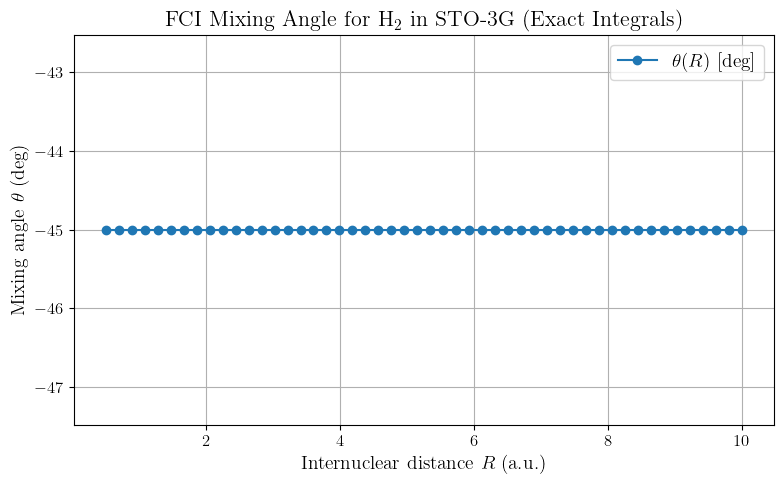

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# STO-3G parameters for hydrogen
c = np.array([0.15432897, 0.53532814, 0.44463454])
alphas = np.array([3.42525091, 0.62391373, 0.16885540])

# Boys function F0(t)
def boys(t):
    if t < 1e-8:
        return 1.0
    else:
        return 0.5 * np.sqrt(np.pi/t) * erf(np.sqrt(t))

# Gaussian overlap between two primitives separated by distance R
def primitive_overlap(alpha, beta, R):
    return (np.pi/(alpha+beta))**1.5 * np.exp(-alpha*beta/(alpha+beta)*R**2)

# Kinetic energy primitive integral between two Gaussians (same centers)
def primitive_kinetic(alpha, beta, R):
    pre = alpha*beta/(alpha+beta)
    return pre * (3 - 2*pre*R**2) * (np.pi/(alpha+beta))**1.5 * np.exp(-alpha*beta/(alpha+beta)*R**2)

# Nuclear attraction primitive integral for a nucleus at C.
# Here, A and B are the centers of the two primitives, and R_AB = |A-B|.
# The product center P = (alpha*A + beta*B)/(alpha+beta), and R_PC = |P - C|.
def primitive_nuclear(alpha, beta, A, B, C, Z):
    R_AB = np.linalg.norm(A - B)
    P = (alpha * A + beta * B) / (alpha + beta)
    R_PC = np.linalg.norm(P - C)
    E = (np.pi/(alpha+beta))**1.5 * np.exp(-alpha*beta/(alpha+beta)*R_AB**2)
    return -Z * 2 * np.pi/(alpha+beta) * E * boys((alpha+beta)*R_PC**2)

# One-electron integral between two STO-3G orbitals centered at A and B.
# nuclei is a list of tuples (center, Z).
def one_electron_integral(A, B, nuclei):
    h = 0.0
    # Sum over all primitive pairs for the two STO-3G orbitals
    for i in range(3):
        for j in range(3):
            R_AB = np.linalg.norm(A - B)
            T = primitive_kinetic(alphas[i], alphas[j], R_AB)
            V = 0.0
            # Compute product center for the (i,j) pair
            for (C, Z) in nuclei:
                V += primitive_nuclear(alphas[i], alphas[j], A, B, C, Z)
            h += c[i]*c[j]*(T + V)
    return h

# Two-electron integral between four STO-3G orbitals.
# For s-orbitals the analytic formula (from Boys, or Szabo & Ostlund) is:
# (ij|kl) = sum_{i,j,k,l} c_i c_j c_k c_l * [2*pi^(5/2)] / [ (alpha_i+alpha_j)(alpha_k+alpha_l) sqrt(alpha_i+alpha_j+alpha_k+alpha_l) ]
#             * exp[ - (alpha_i*alpha_j/(alpha_i+alpha_j)) R_{AB}^2 - (alpha_k*alpha_l/(alpha_k+alpha_l)) R_{CD}^2 ]
#             * exp[ - ((alpha_i+alpha_j)*(alpha_k+alpha_l))/(alpha_i+alpha_j+alpha_k+alpha_l) * |A - C|^2 ]
# For our purposes we define:
def two_electron_integral(A, B, C, D):
    # A,B correspond to first pair; C,D to second pair.
    integral = 0.0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    denom1 = alphas[i] + alphas[j]
                    denom2 = alphas[k] + alphas[l]
                    prefac = 2 * np.pi**2.5 / (denom1 * denom2 * np.sqrt(denom1+denom2))
                    R_AB = np.linalg.norm(A - B)
                    R_CD = np.linalg.norm(C - D)
                    E1 = np.exp(-alphas[i]*alphas[j]/denom1 * R_AB**2)
                    E2 = np.exp(-alphas[k]*alphas[l]/denom2 * R_CD**2)
                    # For two-center integrals, if (A,B) and (C,D) are on different centers,
                    # the product centers are P = A (if A = B) and Q = C (if C = D). For (AA|BB):
                    R_PQ = np.linalg.norm(A - C)
                    exp_factor = np.exp(- (denom1 * denom2/(denom1+denom2)) * R_PQ**2)
                    integral += c[i]*c[j]*c[k]*c[l] * prefac * E1 * E2 * exp_factor
    return integral

# For our H2 system, we define the following integrals:
# Let the two nuclei be A and B.
def g1111(R):
    # (AA|AA): all functions centered on A (A = (-R/2, 0, 0))
    A = np.array([-R/2, 0, 0])
    return two_electron_integral(A, A, A, A)

def g2222(R):
    # (BB|BB)
    B = np.array([R/2, 0, 0])
    return two_electron_integral(B, B, B, B)

def g1122(R):
    # (AA|BB)
    A = np.array([-R/2, 0, 0])
    B = np.array([R/2, 0, 0])
    return two_electron_integral(A, A, B, B)

def g1212(R):
    # (AB|AB)
    A = np.array([-R/2, 0, 0])
    B = np.array([R/2, 0, 0])
    return two_electron_integral(A, B, A, B)

# Now define the one-electron integrals.
# For h11 (orbital on A) the two-electron part sees both nuclei:
def h11(R):
    A = np.array([-R/2, 0, 0])
    B = np.array([-R/2, 0, 0])  # both primitives on A
    # Nuclei: one at A and one at B (with Z=1)
    nuclei = [(np.array([-R/2,0,0]), 1), (np.array([R/2,0,0]), 1)]
    return one_electron_integral(A, B, nuclei)

def h22(R):
    B = np.array([R/2, 0, 0])
    nuclei = [(np.array([-R/2,0,0]), 1), (np.array([R/2,0,0]), 1)]
    return one_electron_integral(B, B, nuclei)

def h12(R):
    A = np.array([-R/2, 0, 0])
    B = np.array([R/2, 0, 0])
    nuclei = [(np.array([-R/2,0,0]), 1), (np.array([R/2,0,0]), 1)]
    return one_electron_integral(A, B, nuclei)

# Now the effective Hamiltonian elements (for the two-determinant model)
def H11(R):
    return 2*h11(R) + g1111(R) + g1122(R)

def H22(R):
    return 2*h22(R) + g2222(R) + g1122(R)  # note: g2211 = g1122 by symmetry

def H12(R):
    return np.sqrt(2)*(h12(R) + g1212(R))

def theta(R):
    # Avoid division by zero
    diff = H11(R) - H22(R)
    return 0.5 * np.arctan2(2*H12(R), diff)

# Now compute theta as a function of internuclear separation R (in atomic units)
R_values = np.linspace(0.5, 10.0, 50)  # fewer points because integrals are more expensive
theta_vals = np.array([theta(R) for R in R_values])
theta_deg = np.degrees(theta_vals)

plt.figure(figsize=(8, 5))
plt.plot(R_values, theta_deg, marker='o', label=r'$\theta(R)$ [deg]')
plt.xlabel('Internuclear distance $R$ (a.u.)')
plt.ylabel(r'Mixing angle $\theta$ (deg)')
plt.title('FCI Mixing Angle for H$_2$ in STO-3G (Exact Integrals)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
